Correct the log distance ratios for the size-limited selection of the SGA.  This follows the method outlined in [Springob et al. (2015)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.1886S/abstract).

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table, join
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy import units as u

from scipy.special import gammaln
from scipy.optimize import minimize

import pickle

import emcee

from corner import corner

import matplotlib.pyplot as plt

# Import data

## Y1 data

In [2]:
filename = 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits'

hdul = fits.open(filename)
SGA_TF = Table(hdul[1].data)
hdr = hdul[0].header
hdul.close()

H0 = hdr['H0']

SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005

## SGA catalog

In [3]:
SGA_path = '/global/cfs/cdirs/cosmo/data/sga/2020/'
SGA_filename = SGA_path + 'SGA-2020.fits'

hdul = fits.open(SGA_filename)
SGA = Table(hdul['ELLIPSE'].data)
# SGA_tractor = Table(hdul['TRACTOR'].data)
hdul.close()

# SGA = join(SGA, SGA_tractor['SGA_ID', 'TYPE', 'SERSIC', 'SHAPE_R'], keys='SGA_ID', join_type='left')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,2025p070,202.5

## NSA

In [4]:
NSA = Table.read('/global/cfs/projectdirs/sdss/data/sdss/dr17/sdss/atlas/v1/nsa_v1_0_1.fits')

NSA[:5]

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY,SERSIC_NMGY_IVAR,SERSIC_OK,SERSIC_RNMGY,SERSIC_ABSMAG,SERSIC_AMIVAR,EXTINCTION,SERSIC_KCORRECT,SERSIC_KCOEFF,SERSIC_MTOL,SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF,PROFMEAN,PROFMEAN_IVAR,QSTOKES,USTOKES,BASTOKES,PHISTOKES,PETRO_FLUX,PETRO_FLUX_IVAR,FIBER_FLUX,FIBER_FLUX_IVAR,PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX,SERSIC_FLUX_IVAR,SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY,CLUMPY,DFLAGS,AID,PID,DVERSION,PROFTHETA,PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE,FIBERID,MJD,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX,ELPETRO_FLUX_IVAR,ELPETRO_TH50,ELPETRO_TH90,ELPETRO_APCORR_R,ELPETRO_APCORR,ELPETRO_APCORR_SELF,ELPETRO_NMGY,ELPETRO_NMGY_IVAR,ELPETRO_OK,ELPETRO_RNMGY,ELPETRO_ABSMAG,ELPETRO_AMIVAR,ELPETRO_KCORRECT,ELPETRO_KCOEFF,ELPETRO_MASS,ELPETRO_MTOL,ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS
bytes19,bytes27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,bytes7,float32,int16,uint8,int16,bytes3,float32,float32,int32,float32,float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[7],float32[5],float32[7],float32,float32,float32,float32,float64,float64,uint8[7],"float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]",float32[7],float32[7],float32[7],float32[7],float32,float32,float32,float32,float32[7],float32[7],float32,float32,float32,float32[7],float32[7],int32[7],int32,int32,bytes8,float32[15],float32,float32,float32,float32,int32,int16,int32,float64,float64,float32,bytes6,bytes27,bytes8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32[7],float32[7],float32[7],float32[7],float32,float32[7],float32[7],float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[5],float32,float32[7],float32,float32,float32,float64
J094651.40-010228.5,09h/m00/J094651.40-010228.5,146.714215072841,-1.0412800233313741,0,72212,37354,-1,-1,-1,15.178774,0.021222278,sdss,0.07,756,1,206,301,136.2967,1095.152,0,0.020687785,29.696056 .. 3267.6895,0.29814342 .. 0.00012172792,1,31.368013 .. 3501.2527,-15.17281 .. -20.302134,223.03555 .. 1102.6129,0.4536473 .. 0.080934174,-0.005893635 .. 0.019576037,0.00017777947 .. 5.1533486e-11,0.00020792194 .. 0.98780394,2.7473723e-05,0.31195974,0.035135116,8898397000.0,215.39407348632812,213.4535369873047,10 .. 12,0.3149959 .. 0.0,233.37904 .. 0.0,0.062215745 .. -0.07950058,0.0006146176 .. -0.1274703,0.8828513 .. 0.7387829,0.2829979 .. -60.97547,18.203371 .. 2264.6604,1.9946122 .. 0.015697604,1.0260131 .. 561.97687,47.3397 .. 0.33574256,0.88909996,14.777527,0.80408496,17.367554,19.554192 .. 3146.785,1.0691423 .. 0.017162137,4.7761517,0.6651653,15.97821,-0.0109440535 .. 0.004525926,0.042470127 .. 0.042621203,0 .. 0,0,36,v2_1_13,0.22341923 .. 258.39,7.2478933,3.4641922,10.453795,5.882104,266,1,51630,146.71420341874853,-1.0412749124036818,0.0,sdss,legacy,good,122,146.71421,-1.0413043,0.80408496,17.367554,1144.0713,0.4582725,7.3913364,3.7061903,10.666219,7.3913364,18.787916 .. 2225.009,1.8480047 .. 0.017611798,5.8557696 .. 3.4004514,11.650886 .. 10.1460905,0.9986329,1.0687045 .. 1.001099,1.0695114 .. 1.0010818,28.532349 .. 2310.4973,0.42499655 .. 0.00024172392,1,28.661283 .. 2337.7668,-15.124495 .. -19.915525,293.50247 .. 1094.6666,-0.010805 .. 0.009306902,3.9630737e-05 .. 2.6251464e-06,6833158000.0,0.00017553588 .. 1.14686,0.004447123,0.09061434,0.025269886,0.0
J094630.85-004554.5,09h/m00/J094630.85-004554.5,146.6285851269414,-0.7651620976591762,1,-1,-1,-1,-1,-1,17.318521,0.06465632,sdss,0.06491773,1239,2,175,301,735.56384,1277.3636,1,0.06403577,2.4606192 .. 443.66675,5.447516 .. 0.006137319,1,2.6590455 .. 454.05856,-14.978118 .. -20.68

# 1. Compute the size function

We're starting by defining the target sample as the full SGA.  This is technically not correct (the TF sample is a subset of the full SGA), but it's easier to start with this.

And we'll compare it to the full NSA (which isn't size-limited), to ensure that the shape that we are fitting is appropriate.

## Compute the physical size of the galaxies

**Note:** We will need to use `Z_LEDA` for the SGA because not all the SGA galaxies have been observed by DESI

In [5]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [80]:
# Mask redshift values of -99 (= missing)
SGA['Z_LEDA'][SGA['Z_LEDA'] == -99] = np.nan

dist = Distance(z=np.abs(SGA['Z_LEDA']), cosmology=Planck18_h)

SGA['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*(SGA['D26']*u.arcmin))

SGA['DIST_MAX'] = 0.5*SGA['D26_kpc']/np.tan(0.1*u.arcmin)


SGA_TF['DIST_DESI_CMB'] = Distance(z=np.abs(SGA_TF['Z_DESI_CMB']), cosmology=Planck18_h)

SGA_TF['D26_kpc'] = 2*SGA_TF['DIST_DESI_CMB'].to('kpc')*np.tan(0.5*(SGA_TF['D26']*u.arcmin))

SGA_TF['DIST_MAX'] = 0.5*SGA_TF['D26_kpc']/np.tan(0.1*u.arcmin)


dist_nsa = Distance(z=np.abs(NSA['Z']), cosmology=Planck18_h)

NSA['R_ELPETRO_kpc'] = 2*dist_nsa.to('kpc')*np.tan(NSA['ELPETRO_THETA_R']*u.arcsec)

NSA['DIST_MAX'] = 0.5*NSA['R_ELPETRO_kpc']/np.tan(0.1*u.arcmin)

## Plot the size function

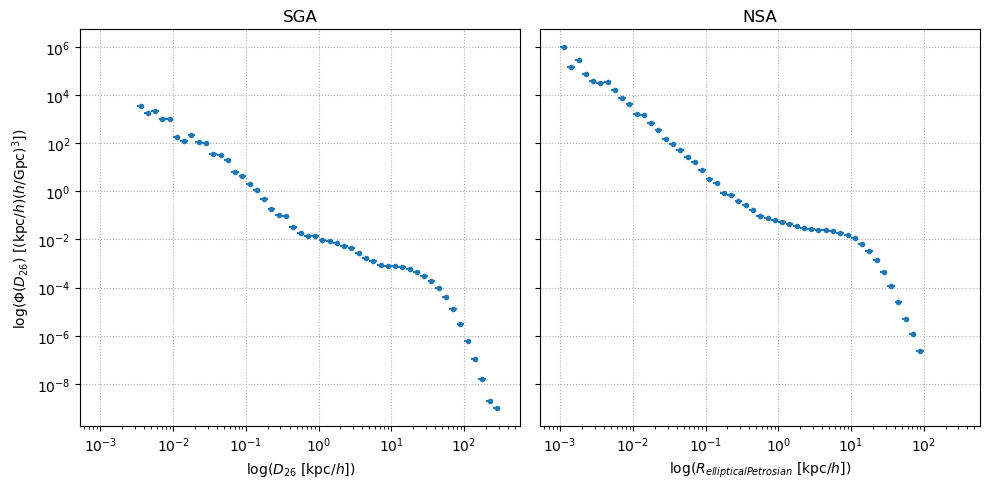

In [7]:
# D26kpc_binwidth = 5
# D26kpc_bins = np.arange(0, 200, D26kpc_binwidth)
D26kpc_bins = np.logspace(-3, 2.5, 56)
D26kpc_binwidth = D26kpc_bins[1:] - D26kpc_bins[:-1]

# ignore NaN values
good = np.isfinite(SGA['DIST_MAX']) & (SGA['DIST_MAX'] > 0)
good_nsa = np.isfinite(NSA['DIST_MAX']) & (NSA['DIST_MAX'] > 0)

size_func, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                                    bins=D26kpc_bins, 
                                    weights=1/SGA['DIST_MAX'][good].to('Mpc').value**3, 
                                    # density=True
                                   )
N, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                            bins=D26kpc_bins)

bin_centers = bin_edges[:-1] + 0.5*D26kpc_binwidth

size_func_nsa, bin_edges = np.histogram(NSA['R_ELPETRO_kpc'][good_nsa], 
                                        bins=D26kpc_bins, 
                                        weights=1/NSA['DIST_MAX'][good_nsa].to('Mpc').value**3
                                       )

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.errorbar(bin_centers, 
            size_func, 
            xerr=0.5*D26kpc_binwidth, 
            # yerr=np.sqrt(N), 
            # yerr=np.sqrt(size_func),
            fmt='.')

ax.set(xscale='log', 
       yscale='log', 
       xlabel='log($D_{26}$ [kpc/$h$])', 
       ylabel=r'log($\Phi(D_{26})$ [(kpc/$h$)($h$/Gpc)$^3$])', 
       title='SGA')

ax.grid(ls=':')

ax = axes[1]
ax.errorbar(bin_centers, 
            size_func_nsa, 
            xerr=0.5*D26kpc_binwidth, 
            # yerr=1/np.sqrt(N), 
            # yerr=np.sqrt(size_func_nsa),
            fmt='.')

ax.grid(ls=':')

ax.set(xlabel='log($R_{elliptical Petrosian}$ [kpc/$h$])', 
       title='NSA');

## Parameterize the size function

We'll try a Schechter function first:
\begin{equation}
  dn(R_{26}) = \phi(R_{26}) dR_{26} = \ln 10 \phi^* \left( \frac{R_{26}}{R_{26}^*} \right)^{\alpha + 1} e^{-R_{26}/R_{26}^*} \, d\log R_{26}
\end{equation}

In [8]:
def Schecht_log(x, dlogx, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    dlogx : float or ndarray of length (N,)
        bin width of x, in log space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs) * dlogx


def power_log(x, dlogx, p, a, xs):
    '''
    Compute a power law (with the same form as Schechter, but no exponential 
    cutoff) for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    dlogx : float or ndarray of length (N,)
        bin width of x, in log space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * dlogx


def Schecht(x, dx, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in linear space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.
    dx : float or ndarray of length (N,)
        bin width of x, in linear space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return p * (x/xs)**a * np.exp(-x/xs) * dx / xs


def logL(params, n, x, dx):
    '''
    Log-likelihood

    PARAMETERS
    ==========
    params : list or ndarray
        List of 2xthree parameters: scale factor, slope, and knee
    n : ndarray
        (weighted) binned counts
    x : ndarray
        Bin centers used to construct the histogrammed counts n
    dx : float or ndarray
        Bin width used to construct the histogrammed counts

    RETURNS
    =======
    logL : float
        Log likelihood of set n given model parameters
    '''

    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2])
    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5])
    lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5]) + Schecht_log(x, dx, 10**params[6], params[7], params[8])
    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5]) + power_log(x, dx, 10**params[6], params[7], params[8])

    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))


def nlogL(params, n, x, dx):
    '''Negative log likelihood, for minimizers'''
    return -logL(params, n, x, dx)

### Fit with `scipy.optimize.minimize`

In [50]:
bounds1 = [[-5, 0], [-2, 0], [10, 20]]
bounds2 = [[-3, 0], [-2, 0], [1, 5]]
bounds3 = [[0, 5], [-5, 0], [0.001, 1]]

p0 = [-2.2, -0.8, 15, -1.1, -1, 2, 2, -2.5, 0.07]

bestfit = minimize(nlogL, 
                   p0, 
                   args=(size_func[N > 0], bin_centers[N > 0], 0.1), 
                   bounds=bounds1 + bounds2 + bounds3)

'''
bestfit = None

for i in range(30):

    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1 + bounds2 + bounds3]
    
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1)
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1 + bounds2)
    result = minimize(nlogL, p0, args=(size_func[N > 0], bin_centers[N > 0], 0.1), bounds=bounds1 + bounds2 + bounds3)

    if result.success:

        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
'''
bestfit

      fun: 493.75604173962904
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.88373807e-03,  1.42222233e-02,  1.70530242e-05, -2.52259726e-01,
        2.33148968e-01, -5.66160455e-03,  2.15777619e-02, -7.11963826e-02,
        1.04785158e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 480
      nit: 28
     njev: 48
   status: 0
  success: True
        x: array([-2.19941469, -0.80145006, 14.99999626, -1.07555201, -1.03550495,
        2.00031719,  2.04799869, -2.70425886,  0.06618088])

In [9]:
'''
# Save fit
temp_outfile = open('SGA_sizefunc_20250311.pickle', 'wb')
pickle.dump((bestfit), temp_outfile)
temp_outfile.close()
'''
# Load fit
temp_infile = open('SGA_sizefunc_20250311.pickle', 'rb')
bestfit = pickle.load(temp_infile)
temp_infile.close()

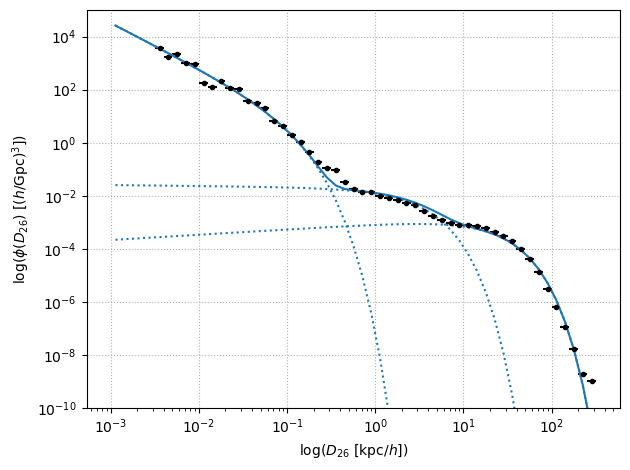

In [10]:
plt.figure(tight_layout=True)

plt.errorbar(bin_centers, 
             size_func, 
             xerr=0.5*D26kpc_binwidth, 
             # yerr=1/np.sqrt(N), 
             # yerr=1/np.sqrt(size_func),
             fmt='.', 
             c='k')

# Actual fit
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]) + Schecht_log(bin_centers, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]) + Schecht_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         # Schecht_log(bin_centers, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]) + Schecht_log(bin_centers, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]) + power_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]),
         ':', c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]),
         ':', c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         # power_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         ':', c='tab:blue'
        )
'''
# Manual fit
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-2.2, -0.8, 15) + Schecht_log(bin_centers, 0.1, 10**-1.1, -1, 2) + Schecht_log(bin_centers, 0.1, 10**2, -2.5, 0.07)
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-2.2, -0.8, 15), # phi_* = 10**6
         ':', c='tab:orange'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-1.1, -1, 2), # phi_* = 10**7
         ':', c='tab:orange'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**2, -2.5, 0.07), # phi_* = 10**7
         ':', c='tab:orange'
        )
'''
plt.xscale('log')
plt.yscale('log')

plt.ylim([10**-10, 10**5])

plt.grid(ls=':')

# plt.xlabel('$D_{26}$ [kpc/$h$]')
plt.xlabel('log($D_{26}$ [kpc/$h$])')
plt.ylabel(r'log($\phi(D_{26})$ [($h$/Gpc)$^3$])');

### Fit with MCMC

In [40]:
def log_prior(theta):
    
    p1, a1, xs1, p2, a2, xs2, p3, a3, xs3 = theta

    if (-5 <= p1 <= 0) and (-2 <= a1 <= 0) and (10 <= xs1 <= 20) and (-3 <= p2 <= 0) and (-2 <= a2 <= 0) and (1 <= xs2 <= 5) and (0 <= p3 <= 5) and (-5 <= a3 <= -2) and (0.001 <= xs3 <= 1):
        return 0.0
    return -np.inf


def log_probability(theta, n, x, dx):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL(theta, n, x, dx)

In [43]:
pos = np.array([-2.2, -0.8, 15, -1.1, -1, 2, 2, -2.5, 0.07]) + 0.01*np.random.randn(32, 9)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                log_probability, 
                                args=(size_func[N > 0], bin_centers[N > 0], 0.1)
                               )
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 721.81it/s]


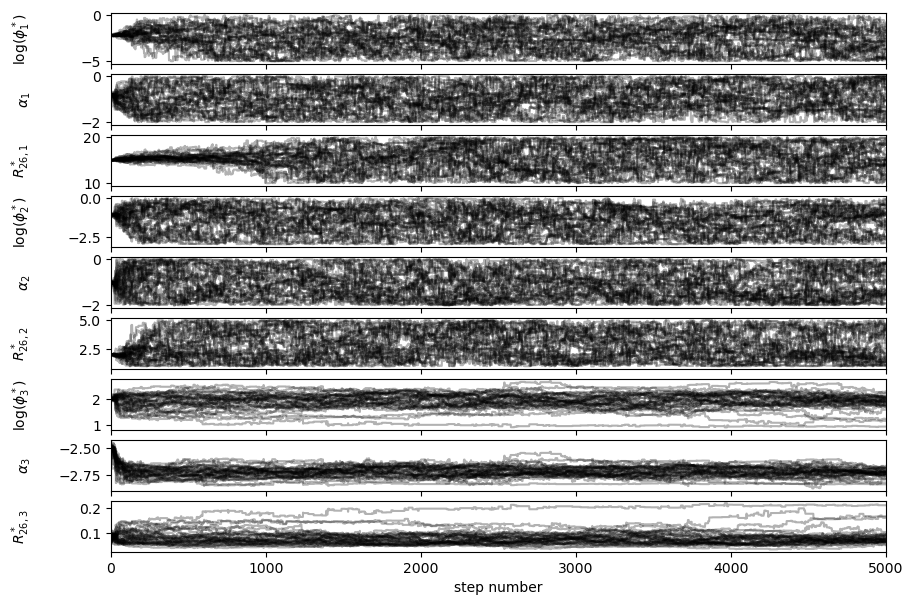

In [44]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"log($\phi_1^*$)", r"$\alpha_1$", "$R_{26,1}^*$", r"log($\phi_2^*$)", r"$\alpha_2$", "$R_{26,2}^*$", r"log($\phi_3^*$)", r"$\alpha_3$", "$R_{26,3}^*$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [45]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 9)


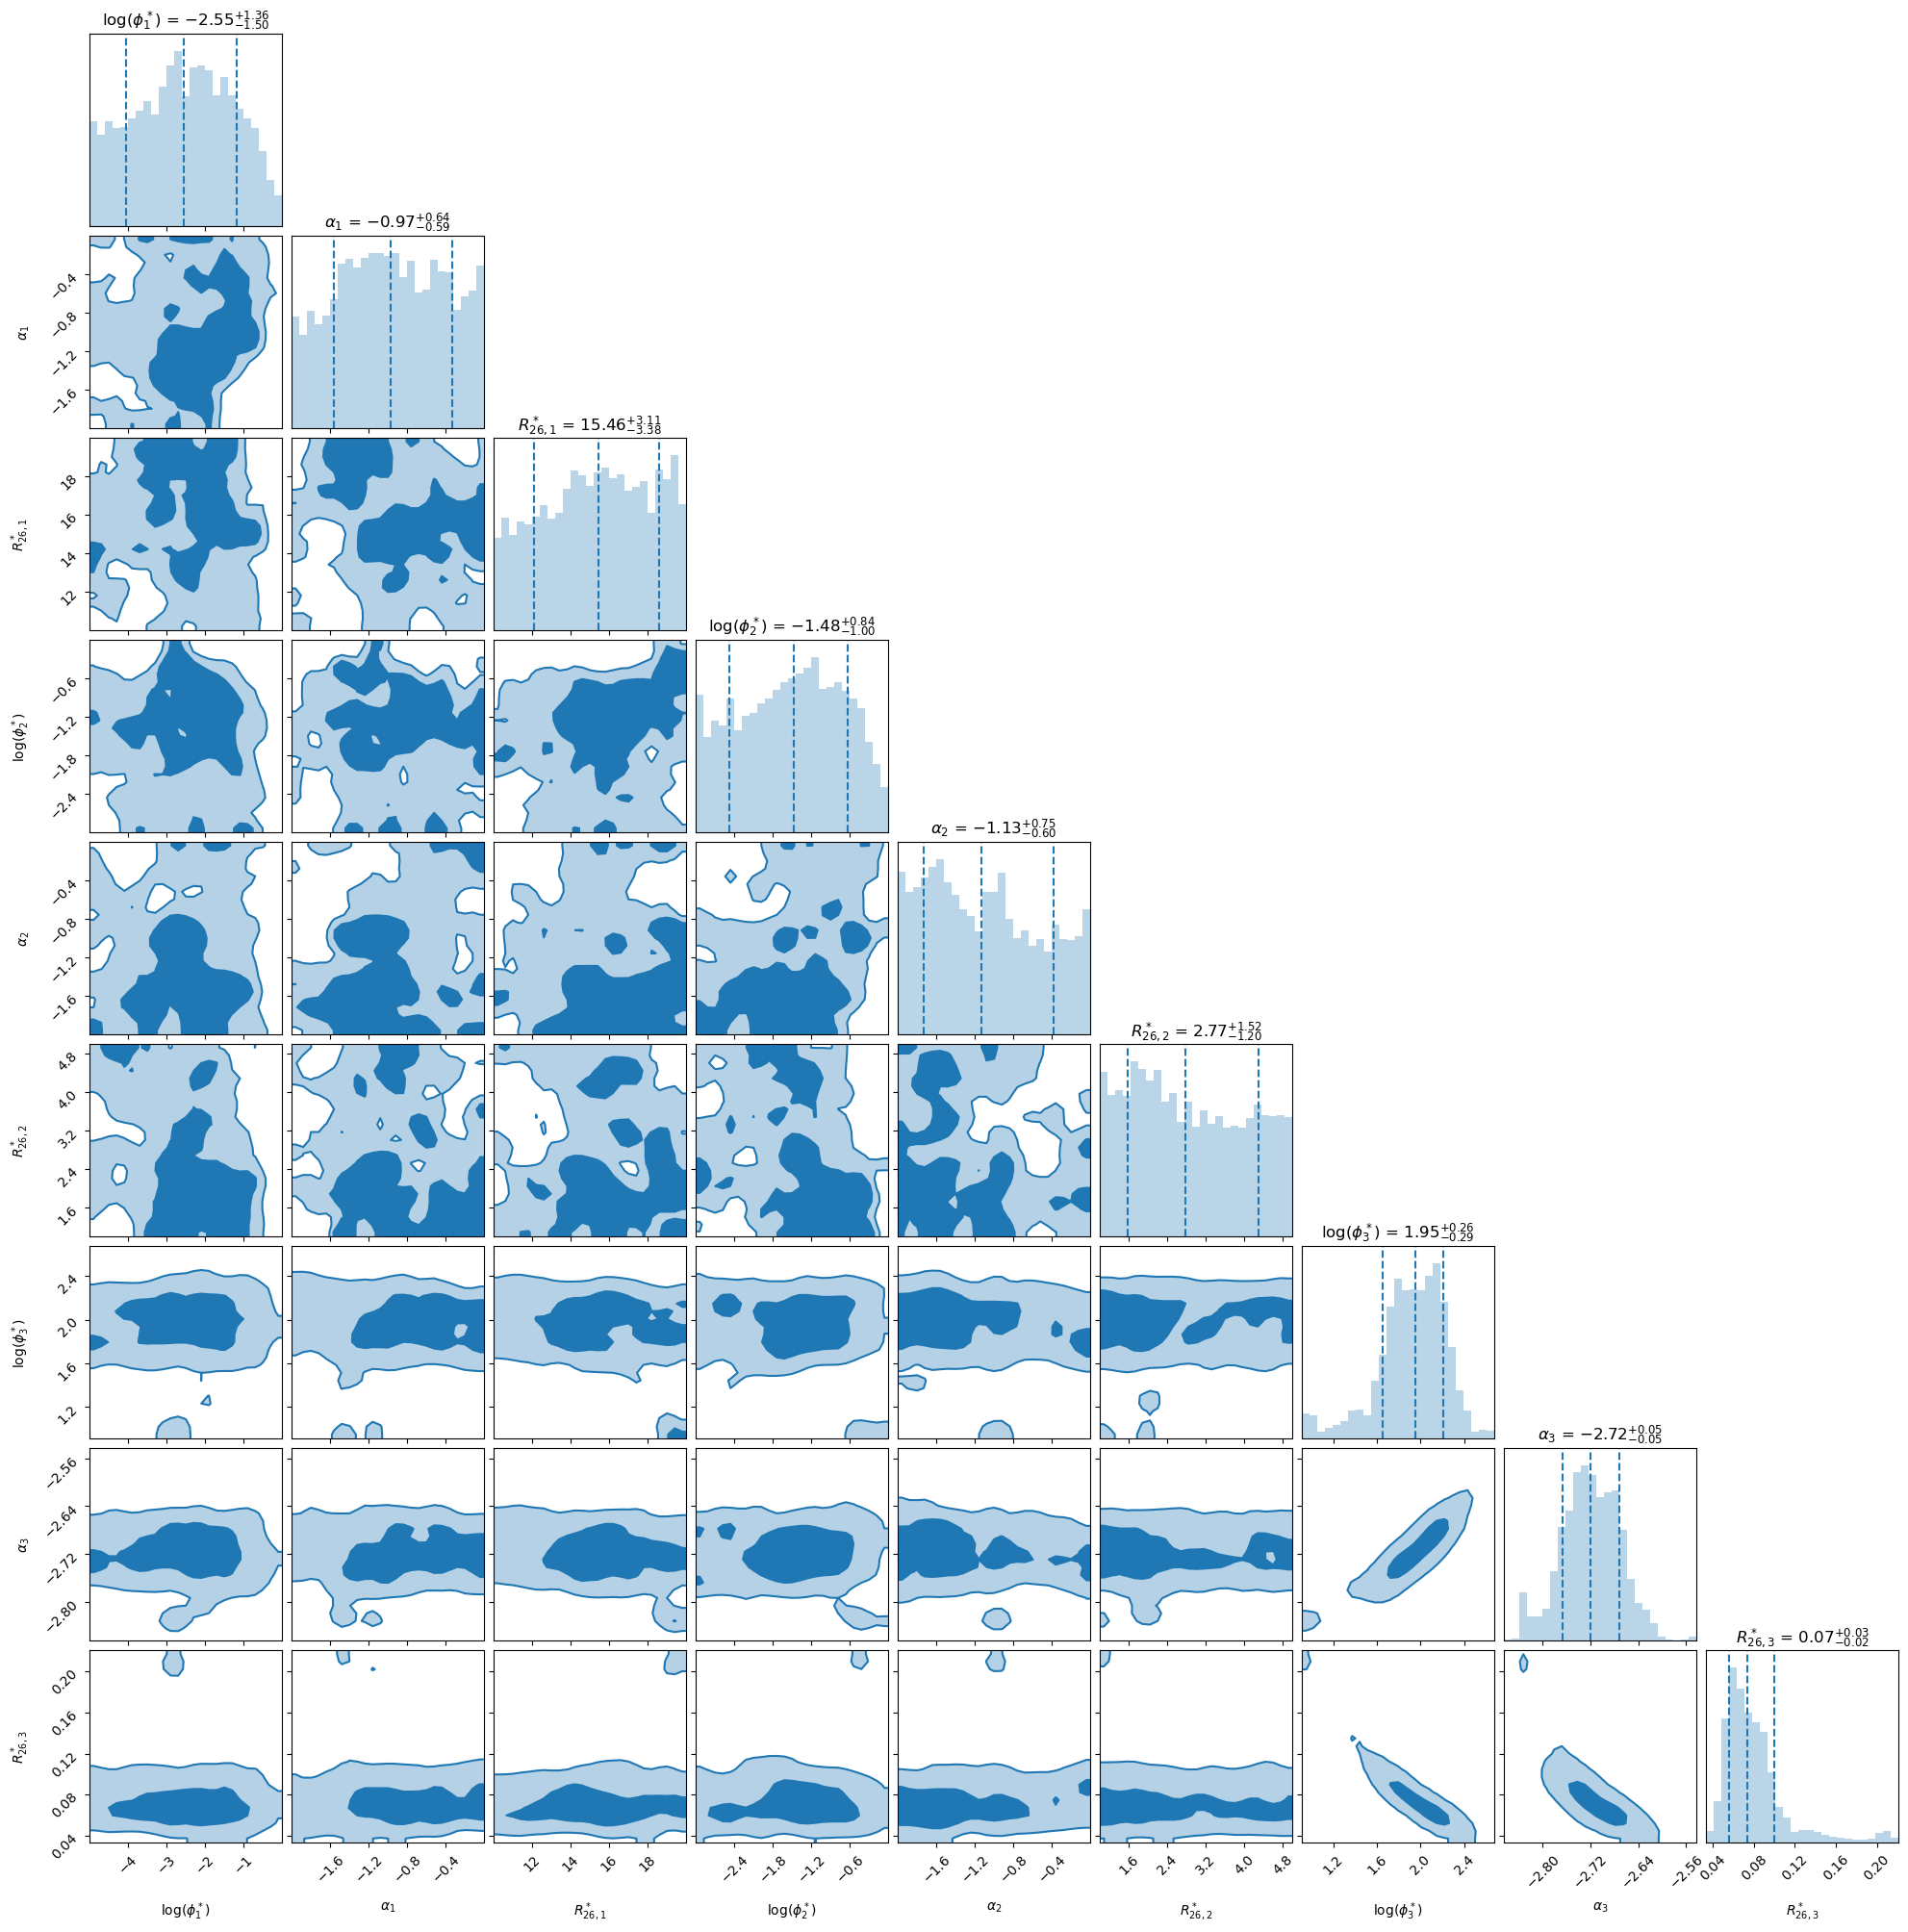

In [46]:
fig = corner(flat_samples, bins=25, smooth=1,
             labels=labels, 
             levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), 
             quantiles=[0.16, 0.5, 0.84], 
             color='tab:blue', 
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
             plot_datapoints=False,
             fill_contours=True, 
             show_titles=True);

# 2. Compute sample completeness

We define the completeness as the fraction of the targeted sample that is included in the final sample within bins of $R_{26}$.

In [11]:
# TF targets
pv_tf  = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_tf.fits')

TF_target_SGAids, target_indices = np.unique(pv_tf['SGA_ID'], return_index=True)
len(TF_target_SGAids)

129772

In [21]:
SGA_targets = join(SGA, pv_tf[['SGA_ID']][target_indices], keys='SGA_ID')

In [77]:
# D26arcmin_binwidth = 0.1
# D26arcmin_bins = np.arange(0.2, np.max(SGA_targets['D26']) + D26arcmin_binwidth, D26arcmin_binwidth)
D26arcmin_bins = np.logspace(-1, 1.6, 27)
D26arcmin_binwidth = D26arcmin_bins[1:] - D26arcmin_bins[:-1]

N_targets, D26arcmin_bin_edges  = np.histogram(SGA_targets['D26'], bins=D26arcmin_bins)

N_obs,_ = np.histogram(SGA_TF['D26'], bins=D26arcmin_bins)

In [78]:
D26arcmin_bin_centers = D26arcmin_bin_edges[:-1] + 0.5*D26arcmin_binwidth

completeness = N_obs/N_targets

/tmp/ipykernel_2076623/3662737051.py:3: RuntimeWarning: invalid value encountered in true_divide
  completeness = N_obs/N_targets


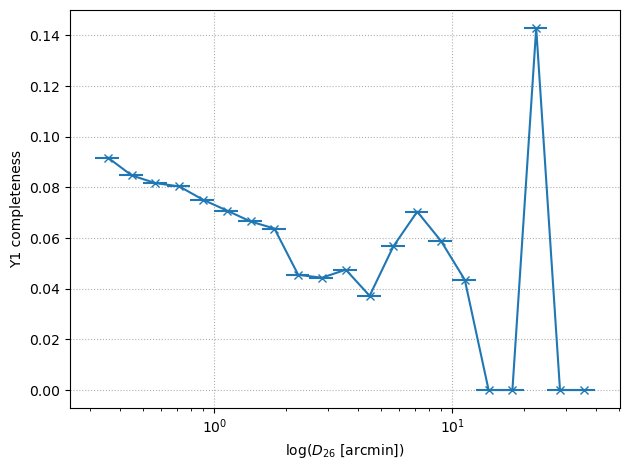

In [79]:
plt.figure(tight_layout=True)

plt.errorbar(D26arcmin_bin_centers[N_targets > 0], 
             completeness[N_targets > 0], 
             xerr=0.5*D26arcmin_binwidth[N_targets > 0],
             fmt='x-'
            )

plt.xscale('log')

plt.grid(ls=':')

plt.xlabel('log($D_{26}$ [arcmin])')
plt.ylabel('Y1 completeness');

# 3. Compute weights for uncorrected $\eta$ distribution

For each $\eta_i$ within 2$\sigma$ of the uncorrected $\eta$, compute its probability $w_i$, where $1/w_i$ is the completeness integrated over the size function evaluated at $\eta_i$.

In [ ]:
# For a given distance modulus, convert the completeness from arcmin to kpc/h
# I think I need to convert the diameters first, and then compute the completeness in the same binning as we used in the size function
def completeness_convert(D26arcmin_target, D26arcmin_obs, dist, D26kpc_bins):
    '''
    Calculate the sample completeness for the given distance

    PARAMETERS
    ==========
    D26arcmin_target : ndarray of shape (N,)
        26 mag/arcsec^2 diameters of the targeted sample, in units of arcmin
    D26arcmin_obs : ndarray of shape (M,)
        26 mag/arcsec^2 diameters of the observed sample, in units of arcmin
    dist : float
        distance for which to convert diameters from arcmin to kpc/h
    D26kpc_bins : ndarray of shape (n,)
        bins within which to compute sample completeness.  Should be the same 
        as those used to compute the size function.

    RETURNS
    =======
    completeness : ndarray of shape (n-1,)
        fraction of targeted galaxies that were observed in each bin
    '''
    # Convert diameters to kpc/h
    D26kpc_target = 2*dist.to('kpc')*np.tan(0.5*D26arcmin_target*u.arcmin)
    D26kpc_obs = 2*dist.to('kpc')*np.tan(0.5*D26arcmin_obs*u.arcmin)

    # Compute number of galaxies in each bin
    Ntarget,_ = np.histogram(D26kpc_target, bins=D26kpc_bins)
    Nobs,_ = np.histogram(D26kpc_obs, bins=D26kpc_bins)

    # Compute fraction of galaxies observed in each bin
    return Nobs/Ntarget